# Setup


In [1]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
! ln -s /content/drive/MyDrive/aml-assignments/assignment-1/ assignment-1

In [3]:
! pip install torchmetrics torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.6 MB/s eta 0:00:00


# Imports


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary
import torchmetrics
import torchvision
from torchvision import datasets, transforms, utils

In [5]:
from tqdm import tqdm
import os
import gc

# Creating the dataset class


In [ ]:
print("__CUDNN VERSION:", torch.backends.cudnn.version())
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__CUDA Device Name:", torch.cuda.get_device_name(0))
print(
    "__CUDA Device Total Memory [GB]:",
    torch.cuda.get_device_properties(0).total_memory / 1e9,
)

__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.835398144


In [ ]:
!nvidia-smi

Sat Oct 14 12:52:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# constants

BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class SignLanguageMnist(Dataset):
    def __init__(self, img_file, transform=None, subset=None, device="cpu"):
        self.labels_map = {
            idx: chr(letter) for idx, letter in zip(range(26), range(65, 91))
        }
        self.imgs = pd.read_csv(img_file)
        if subset is not None:
            self.imgs = self.imgs.loc[subset, :].reset_index(drop=True)
        self.labels = torch.tensor(self.imgs["label"], device=device)
        self.imgs.drop(columns=["label"], inplace=True)
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = torch.tensor(self.imgs.loc[index, :]).view((1, 28, 28)) / 255
        if self.transform:
            img = self.transform(img)
        img = img.to(self.device)
        return img, self.labels[index]

# DNN


In [8]:
class DeepNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 26),
        )
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        predictions = self.logsoftmax(logits)
        return predictions


dnn = DeepNN().to(DEVICE)
print(summary(dnn, (BATCH_SIZE, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
DeepNN                                   [128, 26]                 --
├─Flatten: 1-1                           [128, 784]                --
├─Sequential: 1-2                        [128, 26]                 --
│    └─Linear: 2-1                       [128, 200]                157,000
│    └─ReLU: 2-2                         [128, 200]                --
│    └─Linear: 2-3                       [128, 100]                20,100
│    └─ReLU: 2-4                         [128, 100]                --
│    └─Linear: 2-5                       [128, 60]                 6,060
│    └─ReLU: 2-6                         [128, 60]                 --
│    └─Linear: 2-7                       [128, 26]                 1,586
├─LogSoftmax: 1-3                        [128, 26]                 --
Total params: 184,746
Trainable params: 184,746
Non-trainable params: 0
Total mult-adds (M): 23.65
Input size (MB): 0.40
Forward/backward pa

# CNN


In [9]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=24, kernel_size=6, padding=0
        )
        self.conv3 = nn.Conv2d(
            in_channels=24, out_channels=32, kernel_size=6, padding=0
        )
        self.fc1 = nn.Linear(128, 200)
        self.fc2 = nn.Linear(200, 26)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        logits = self.fc2(x)
        predictions = self.logsoftmax(logits)
        return predictions


cnn = CNN().to(DEVICE)
print(summary(cnn, (BATCH_SIZE, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [128, 26]                 --
├─Conv2d: 1-1                            [128, 12, 26, 26]         120
├─ReLU: 1-2                              [128, 12, 26, 26]         --
├─Conv2d: 1-3                            [128, 24, 21, 21]         10,392
├─ReLU: 1-4                              [128, 24, 21, 21]         --
├─MaxPool2d: 1-5                         [128, 24, 10, 10]         --
├─Conv2d: 1-6                            [128, 32, 5, 5]           27,680
├─ReLU: 1-7                              [128, 32, 5, 5]           --
├─MaxPool2d: 1-8                         [128, 32, 2, 2]           --
├─Flatten: 1-9                           [128, 128]                --
├─Linear: 1-10                           [128, 200]                25,800
├─Linear: 1-11                           [128, 26]                 5,226
├─LogSoftmax: 1-12                       [128, 26]                 --

In [10]:
class CNNDropout(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=24, kernel_size=6, padding=0
        )
        self.conv3 = nn.Conv2d(
            in_channels=24, out_channels=32, kernel_size=6, padding=0
        )
        self.fc1 = nn.Linear(128, 200)
        self.fc2 = nn.Linear(200, 26)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.8)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        predictions = self.logsoftmax(logits)
        return predictions


cnn = CNNDropout().to(DEVICE)
print(summary(cnn, (BATCH_SIZE, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
CNNDropout                               [128, 26]                 --
├─Conv2d: 1-1                            [128, 12, 26, 26]         120
├─ReLU: 1-2                              [128, 12, 26, 26]         --
├─Conv2d: 1-3                            [128, 24, 21, 21]         10,392
├─ReLU: 1-4                              [128, 24, 21, 21]         --
├─MaxPool2d: 1-5                         [128, 24, 10, 10]         --
├─Conv2d: 1-6                            [128, 32, 5, 5]           27,680
├─ReLU: 1-7                              [128, 32, 5, 5]           --
├─MaxPool2d: 1-8                         [128, 32, 2, 2]           --
├─Flatten: 1-9                           [128, 128]                --
├─Linear: 1-10                           [128, 200]                25,800
├─ReLU: 1-11                             [128, 200]                --
├─Dropout: 1-12                          [128, 200]                --
├─

# Training Loop


In [11]:
def train_one_epoch(
    model, train, loss_fn, optimizer, metric, device, epoch, permutation
):
    loop = tqdm(train)
    for inputs, targets in loop:  # iterates over all the batches
        loop.set_description_str(f"Epoch = {epoch}")
        inputs, targets = inputs.to(device), targets.to(device)
        # permute the image pixels in case of scrambling
        if permutation is not None:
            inputs = inputs.view(-1, 784)[:, permutation]
            inputs = inputs.view(-1, 1, 28, 28)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        for param in model.parameters():
            param.grad = None
        loss.backward()
        optimizer.step()
        loop.set_postfix_str(f"Loss = {loss.item(): .3f}")


def train(
    model, train, test, loss_fn, optimizer, metric, device, epochs, name, permutation
):
    for i in range(epochs):  # iterates over the epochs
        model.train(True)
        train_one_epoch(
            model, train, loss_fn, optimizer, metric, device, i + 1, permutation
        )
        loss, acc = test_one_epoch(model, test, loss_fn, metric, device, permutation)
        print(f"Test loss = {loss: .3f} | Test cccuracy = {100. * acc: .2f}")
    # return training_loss_per_epoch, training_accuracy_per_epoch, test_loss_per_epoch, test_accuracy_per_epoch
    return


@torch.no_grad()
def test_one_epoch(model, test, loss_fn, metric, device, permutation):
    model.train(False)
    running_loss, running_accuracy = [], []
    for inputs, targets in test:
        inputs, targets = inputs.to(device), targets.to(device)
        if permutation is not None:
            inputs = inputs.view(-1, 784)[:, permutation]
            inputs = inputs.view(-1, 1, 28, 28)
        output = model(inputs)
        loss = loss_fn(output, targets)
        predictions = output.argmax(dim=1, keepdim=True).squeeze()
        accuracy = metric(predictions, targets)
        running_loss.append(loss.to("cpu").item())
        running_accuracy.append(accuracy.to("cpu"))

    return np.mean(running_loss), np.mean(running_accuracy)

In [12]:
def train_network(
    model, train_dataloader, test_dataloader, epochs=EPOCHS, name=None, permutation=None
):
    loss_fn = nn.NLLLoss().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=26, top_k=1).to(
        DEVICE
    )
    train(
        model,
        train_dataloader,
        test_dataloader,
        loss_fn,
        optimizer,
        metric,
        DEVICE,
        epochs,
        name,
        permutation,
    )
    torch.save(model.state_dict(), f"assignment-1/saved-model/{name}.pth")

In [13]:
def visualise_individual_predictions(
    img, pred_label, real_label, predicted_probabilities
):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].axis("off")
    axs[1].bar(np.arange(26), predicted_probabilities)
    axs[1].set_xticks(np.arange(26))
    axs[1].set_xticklabels(np.arange(26))
    axs[1].set_title("Prediction Probability")
    axs[1].set_ylim(0, 1.1)
    axs[0].set_title(f"predicted = {pred_label} | real = {real_label}")
    plt.tight_layout()


def visualise_performance(model, permutation=None):
    model.to(DEVICE)
    image_batch, label_batch = next(iter(test_dataloader))
    if permutation is not None:
        image_batch = image_batch.view(-1, 28 * 28)
        image_batch = image_batch[:, permutation]
        image_batch = image_batch.view(-1, 1, 28, 28)

    with torch.no_grad():
        log_predicted_probabilities_batch = model(image_batch)
        for i in range(10):
            img = image_batch[i].to("cpu").squeeze()
            real_label = label_batch[i].to("cpu").item()
            log_predicted_probabilities = log_predicted_probabilities_batch[i].to("cpu")
            predicted_probabilities = torch.exp(log_predicted_probabilities).numpy()
            predicted_label = np.argmax(predicted_probabilities)
            visualise_individual_predictions(
                img, predicted_label, real_label, predicted_probabilities
            )

In [14]:
train_data = SignLanguageMnist(
    "assignment-1/data/sign-language-mnist/sign_mnist_train.csv", device=DEVICE
)
test_data = SignLanguageMnist(
    "assignment-1/data/sign-language-mnist/sign_mnist_test.csv", device=DEVICE
)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1000)

# Results


In [ ]:
model = DeepNN().to(DEVICE)
train_network(model, train_dataloader, test_dataloader, 15, "dnn")

Epoch = 1: 100%|██████████| 215/215 [01:00<00:00,  3.58it/s, Loss =  2.052]


Test loss =  2.235 | Test cccuracy =  28.14


Epoch = 2: 100%|██████████| 215/215 [00:59<00:00,  3.60it/s, Loss =  1.419]


Test loss =  1.788 | Test cccuracy =  42.04


Epoch = 3: 100%|██████████| 215/215 [01:00<00:00,  3.56it/s, Loss =  1.357]


Test loss =  1.596 | Test cccuracy =  45.76


Epoch = 4: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.748]


Test loss =  1.425 | Test cccuracy =  53.96


Epoch = 5: 100%|██████████| 215/215 [01:00<00:00,  3.58it/s, Loss =  0.845]


Test loss =  1.286 | Test cccuracy =  59.03


Epoch = 6: 100%|██████████| 215/215 [00:59<00:00,  3.59it/s, Loss =  0.663]


Test loss =  1.207 | Test cccuracy =  61.20


Epoch = 7: 100%|██████████| 215/215 [01:01<00:00,  3.51it/s, Loss =  0.799]


Test loss =  1.252 | Test cccuracy =  61.13


Epoch = 8: 100%|██████████| 215/215 [00:59<00:00,  3.59it/s, Loss =  0.446]


Test loss =  1.249 | Test cccuracy =  60.57


Epoch = 9: 100%|██████████| 215/215 [00:59<00:00,  3.61it/s, Loss =  0.670]


Test loss =  1.168 | Test cccuracy =  65.09


Epoch = 10: 100%|██████████| 215/215 [01:01<00:00,  3.49it/s, Loss =  0.413]


Test loss =  1.257 | Test cccuracy =  62.38


Epoch = 11: 100%|██████████| 215/215 [00:59<00:00,  3.61it/s, Loss =  0.281]


Test loss =  1.263 | Test cccuracy =  64.95


Epoch = 12: 100%|██████████| 215/215 [00:59<00:00,  3.59it/s, Loss =  0.287]


Test loss =  1.265 | Test cccuracy =  64.61


Epoch = 13: 100%|██████████| 215/215 [01:00<00:00,  3.55it/s, Loss =  0.400]


Test loss =  1.193 | Test cccuracy =  68.02


Epoch = 14: 100%|██████████| 215/215 [01:01<00:00,  3.48it/s, Loss =  0.243]


Test loss =  1.280 | Test cccuracy =  68.12


Epoch = 15: 100%|██████████| 215/215 [00:59<00:00,  3.60it/s, Loss =  0.187]


Test loss =  1.358 | Test cccuracy =  66.13


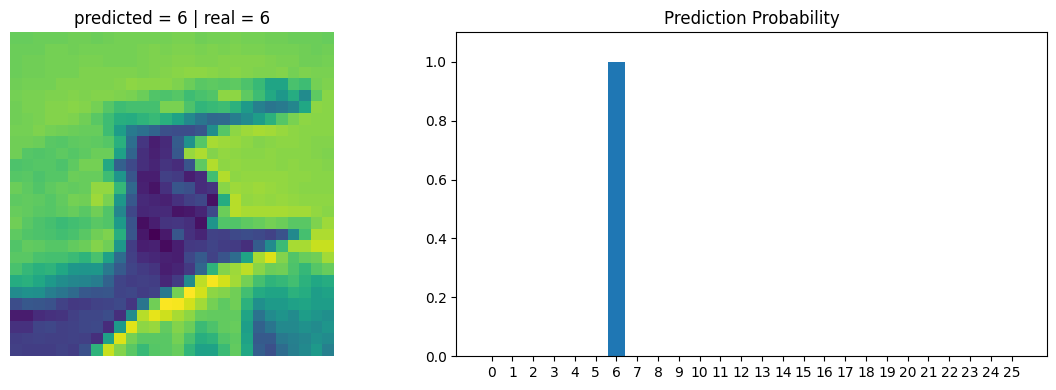

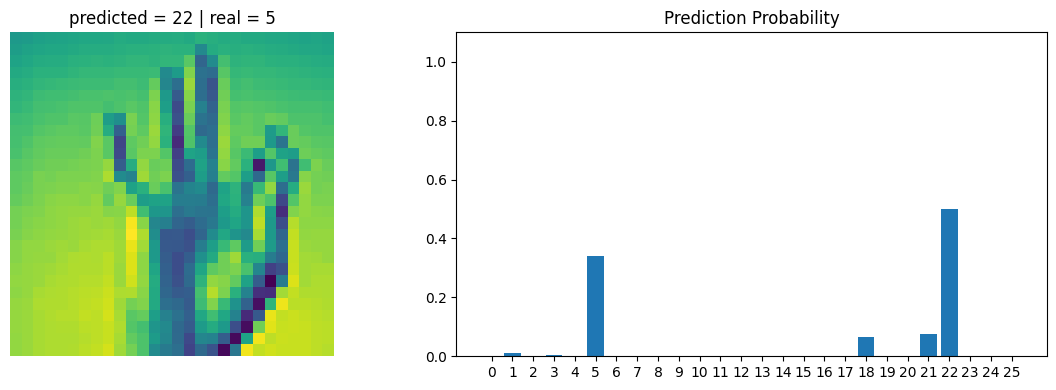

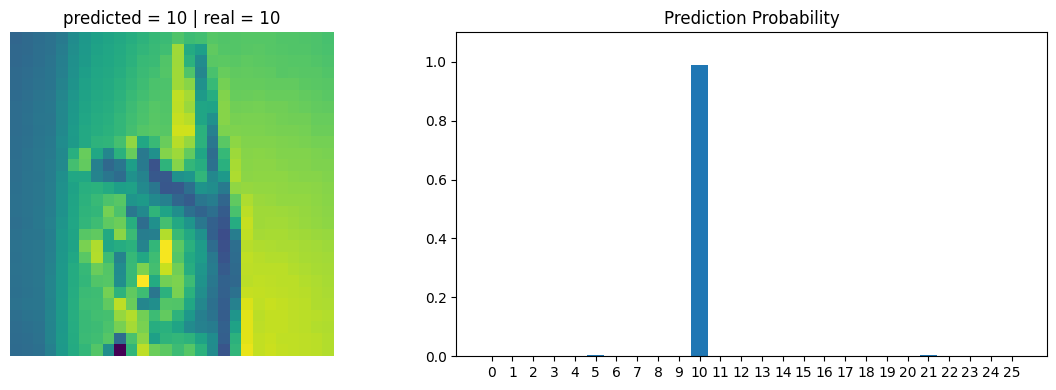

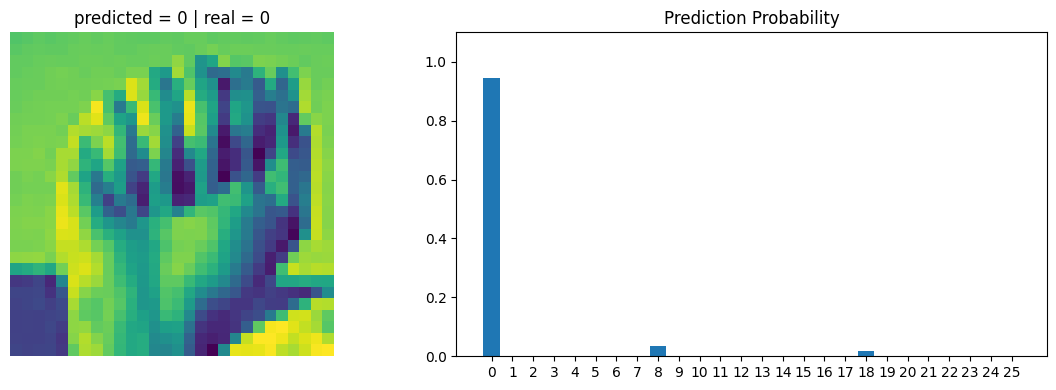

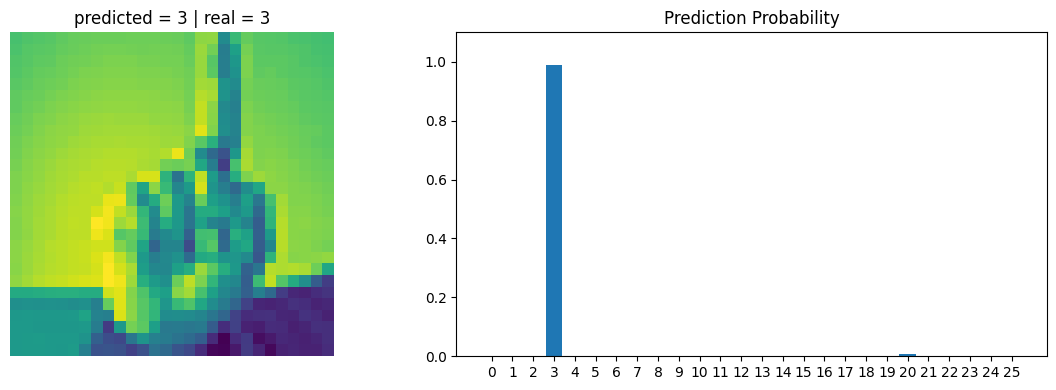

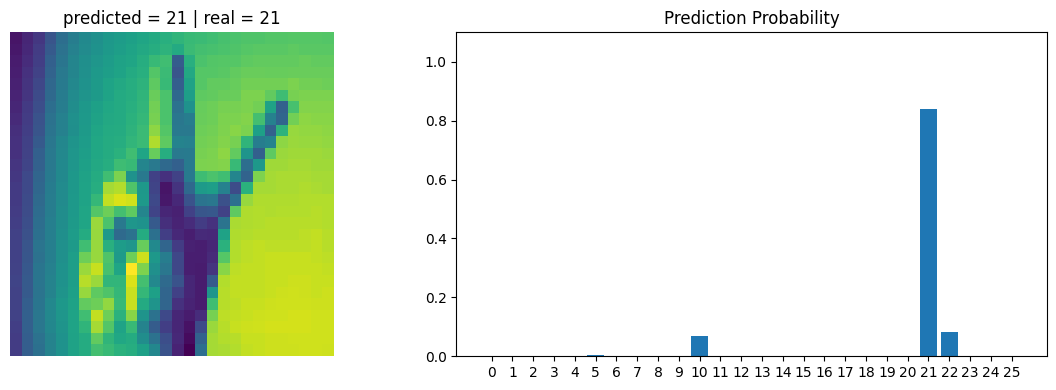

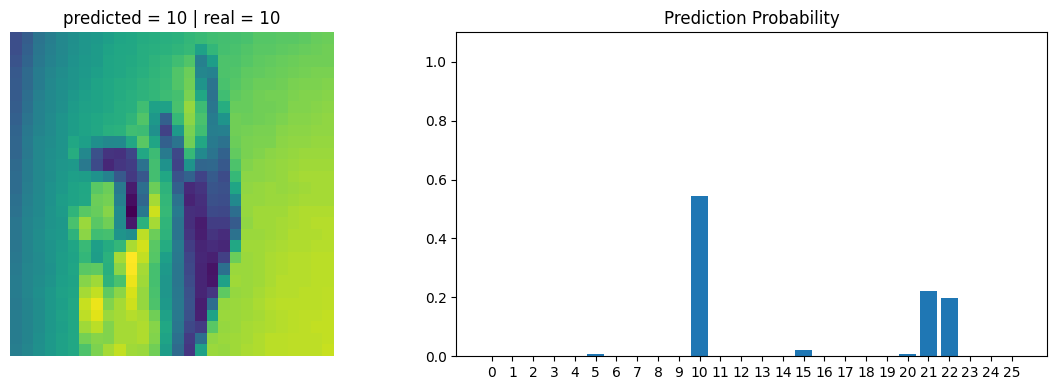

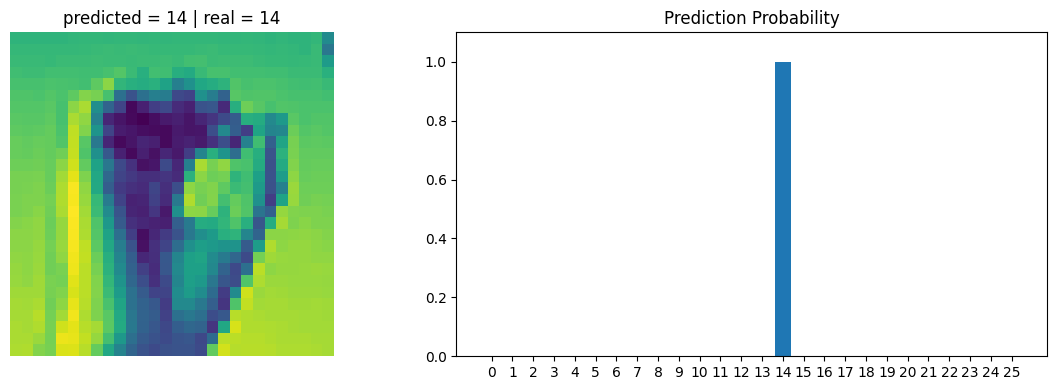

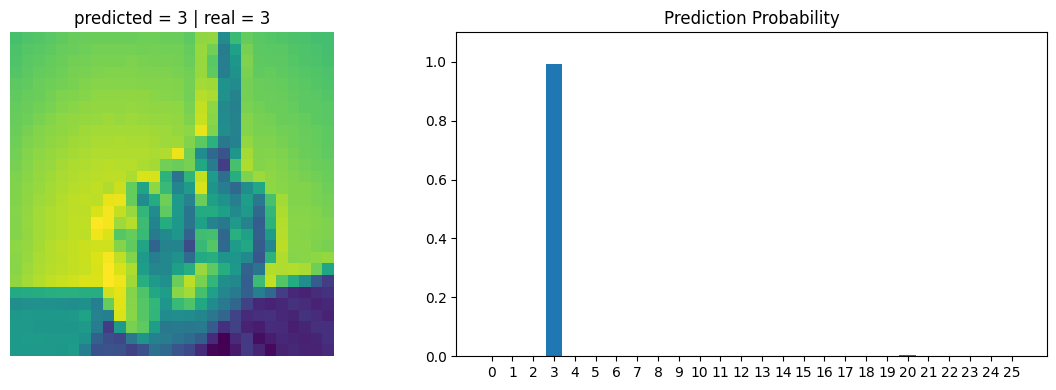

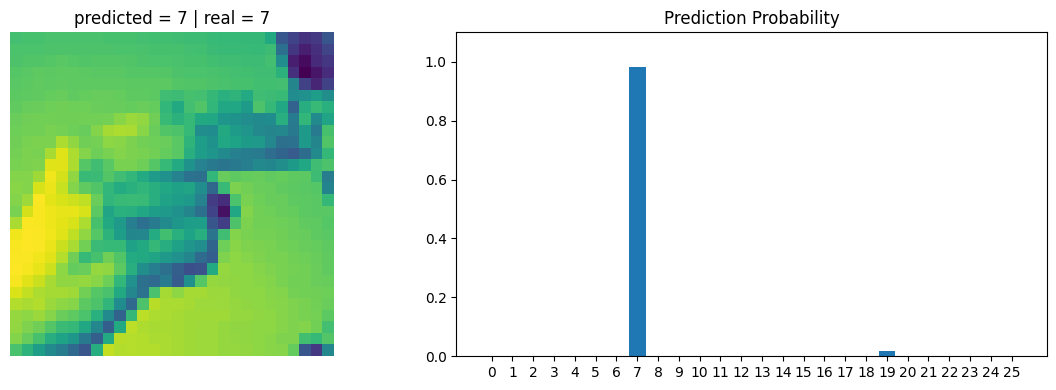

In [ ]:
visualise_performance(model)

In [ ]:
model = CNN().to(DEVICE)
train_network(model, train_dataloader, test_dataloader, 15, "cnn")

Epoch = 1: 100%|██████████| 215/215 [01:01<00:00,  3.48it/s, Loss =  1.333]


Test loss =  1.485 | Test cccuracy =  50.48


Epoch = 2: 100%|██████████| 215/215 [01:01<00:00,  3.52it/s, Loss =  0.743]


Test loss =  0.979 | Test cccuracy =  69.45


Epoch = 3: 100%|██████████| 215/215 [01:02<00:00,  3.45it/s, Loss =  0.564]


Test loss =  0.862 | Test cccuracy =  73.56


Epoch = 4: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.305]


Test loss =  0.786 | Test cccuracy =  76.12


Epoch = 5: 100%|██████████| 215/215 [01:01<00:00,  3.51it/s, Loss =  0.274]


Test loss =  0.816 | Test cccuracy =  77.41


Epoch = 6: 100%|██████████| 215/215 [01:03<00:00,  3.41it/s, Loss =  0.252]


Test loss =  0.858 | Test cccuracy =  76.91


Epoch = 7: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.071]


Test loss =  0.876 | Test cccuracy =  78.41


Epoch = 8: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.123]


Test loss =  1.144 | Test cccuracy =  78.08


Epoch = 9: 100%|██████████| 215/215 [01:02<00:00,  3.42it/s, Loss =  0.065]


Test loss =  1.179 | Test cccuracy =  78.87


Epoch = 10: 100%|██████████| 215/215 [01:00<00:00,  3.53it/s, Loss =  0.084]


Test loss =  1.200 | Test cccuracy =  77.55


Epoch = 11: 100%|██████████| 215/215 [01:02<00:00,  3.42it/s, Loss =  0.034]


Test loss =  1.297 | Test cccuracy =  79.95


Epoch = 12: 100%|██████████| 215/215 [01:01<00:00,  3.50it/s, Loss =  0.012]


Test loss =  1.277 | Test cccuracy =  79.95


Epoch = 13: 100%|██████████| 215/215 [01:01<00:00,  3.51it/s, Loss =  0.021]


Test loss =  1.441 | Test cccuracy =  79.95


Epoch = 14: 100%|██████████| 215/215 [01:03<00:00,  3.37it/s, Loss =  0.029]


Test loss =  1.344 | Test cccuracy =  80.73


Epoch = 15: 100%|██████████| 215/215 [01:01<00:00,  3.52it/s, Loss =  0.024]


Test loss =  1.363 | Test cccuracy =  79.48


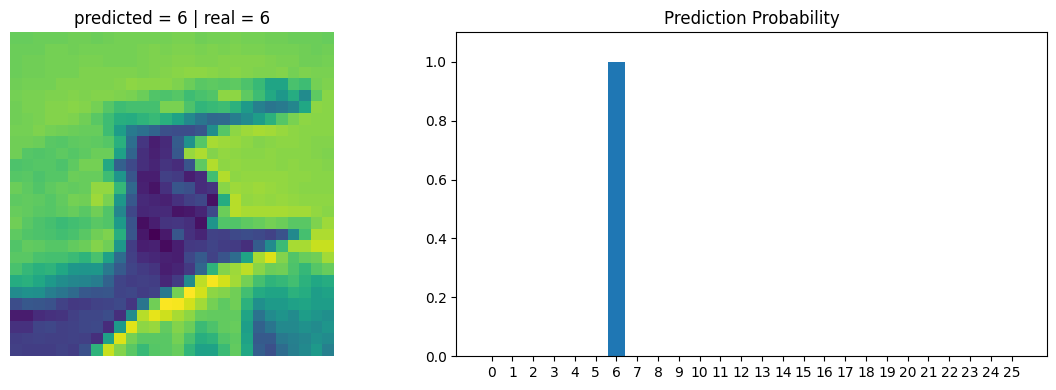

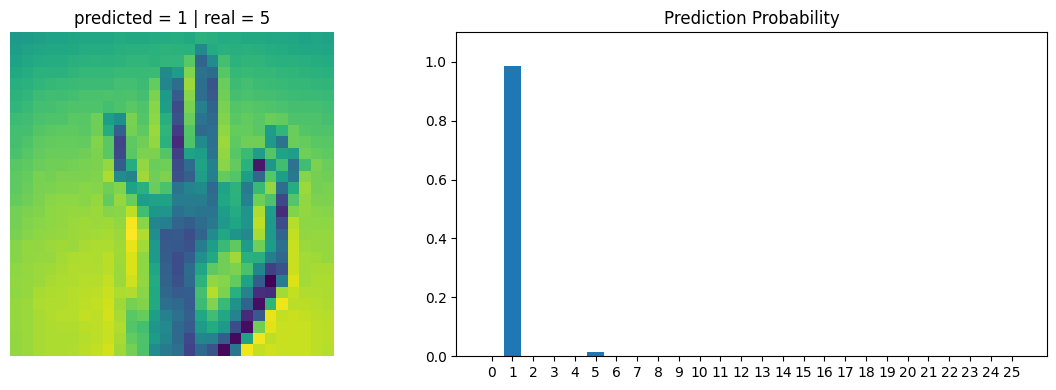

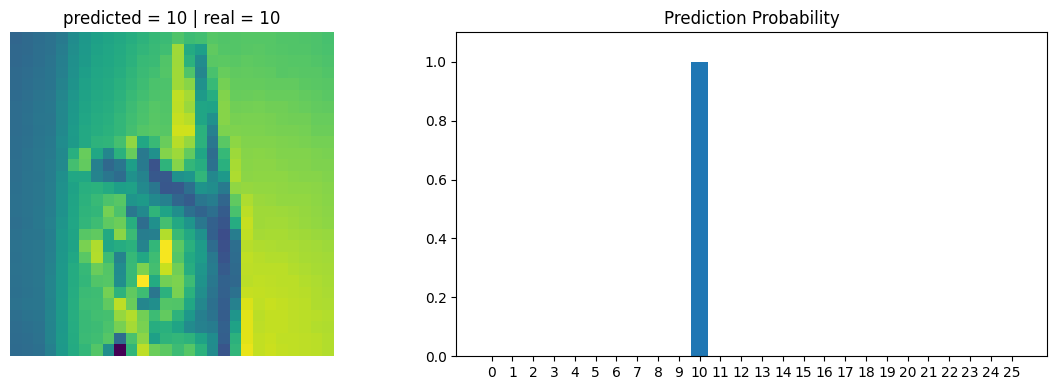

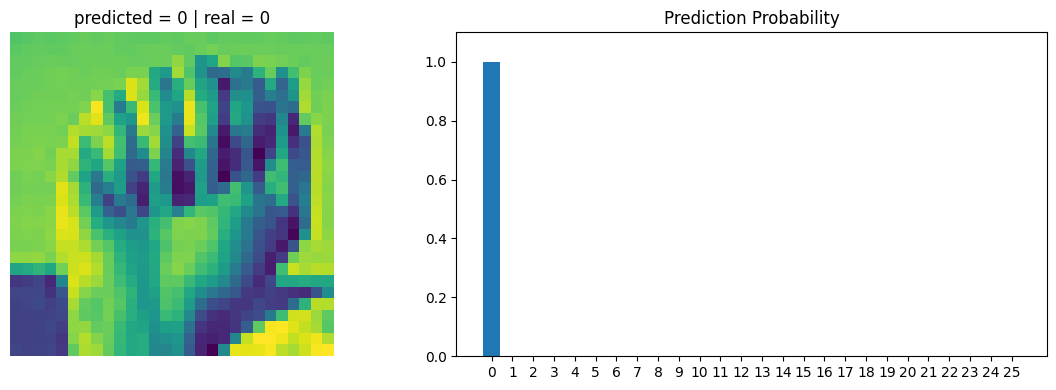

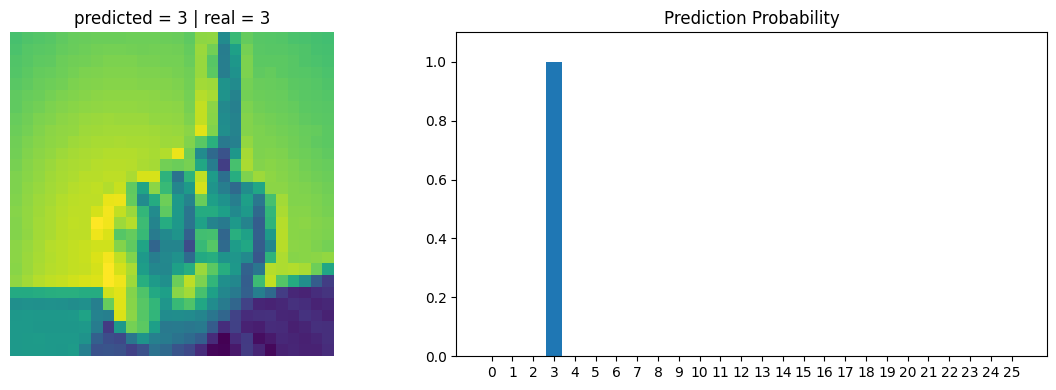

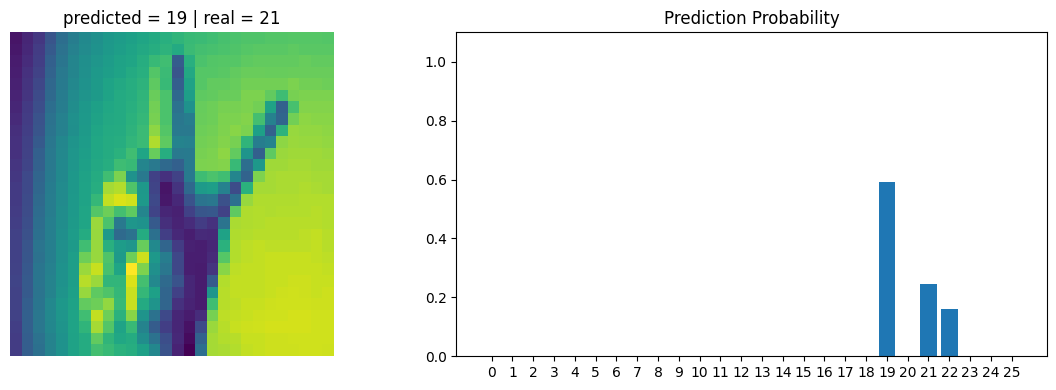

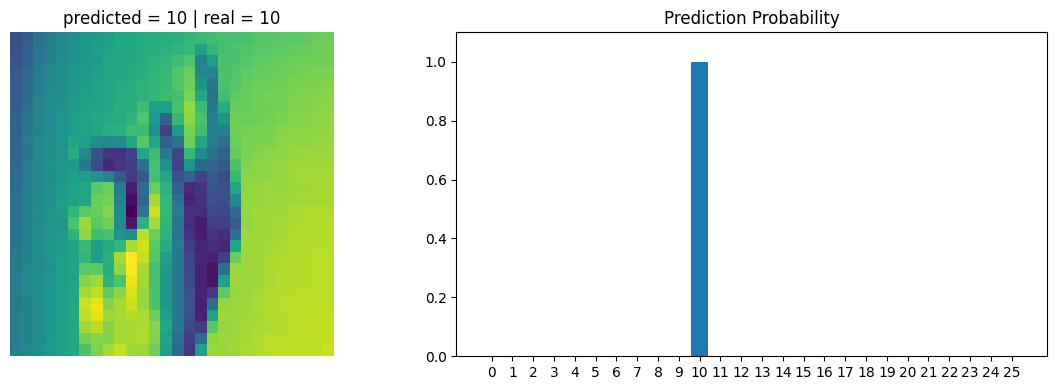

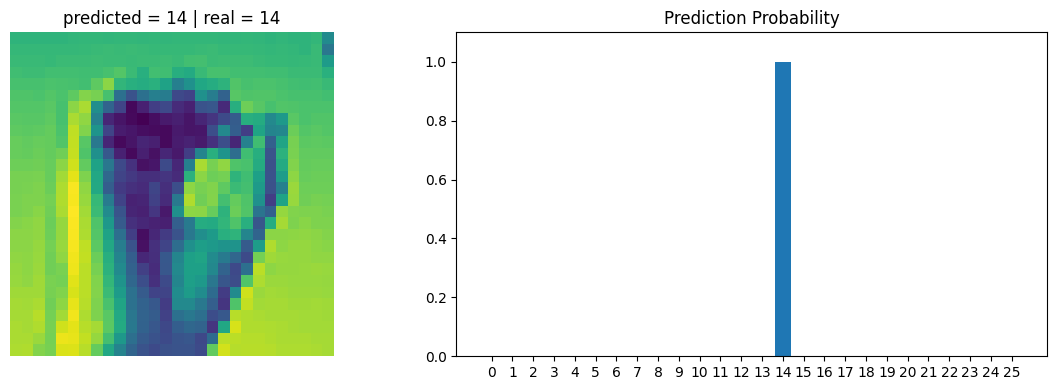

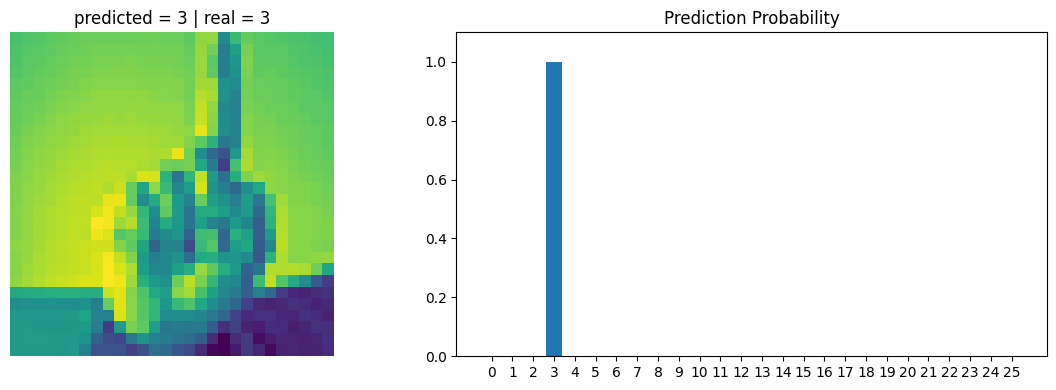

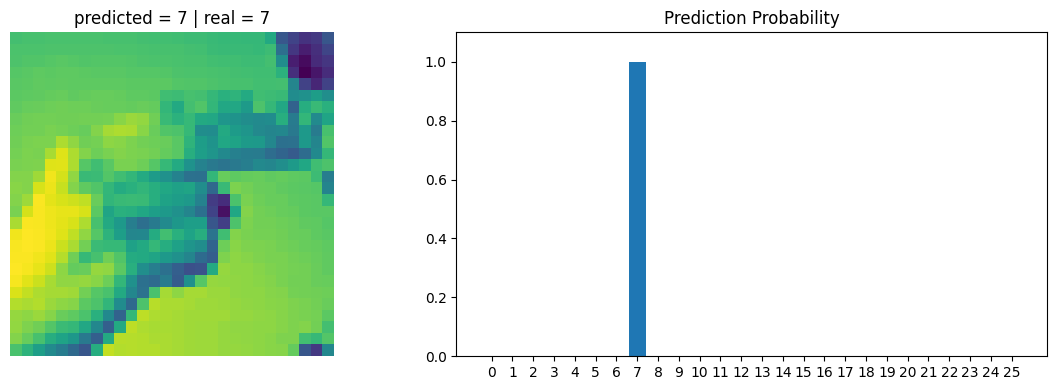

In [ ]:
visualise_performance(model)

In [23]:
model = CNNDropout().to(DEVICE)
train_network(model, train_dataloader, test_dataloader, 15, "cnndropout")

Epoch = 1: 100%|██████████| 215/215 [00:58<00:00,  3.68it/s, Loss =  2.211]


Test loss =  1.963 | Test cccuracy =  37.24


Epoch = 2: 100%|██████████| 215/215 [01:01<00:00,  3.51it/s, Loss =  1.376]


Test loss =  1.259 | Test cccuracy =  58.71


Epoch = 3: 100%|██████████| 215/215 [00:58<00:00,  3.67it/s, Loss =  1.216]


Test loss =  0.929 | Test cccuracy =  65.76


Epoch = 4: 100%|██████████| 215/215 [00:59<00:00,  3.62it/s, Loss =  0.702]


Test loss =  0.766 | Test cccuracy =  74.00


Epoch = 5: 100%|██████████| 215/215 [01:00<00:00,  3.57it/s, Loss =  0.613]


Test loss =  0.666 | Test cccuracy =  78.37


Epoch = 6: 100%|██████████| 215/215 [00:58<00:00,  3.65it/s, Loss =  0.555]


Test loss =  0.661 | Test cccuracy =  77.62


Epoch = 7: 100%|██████████| 215/215 [00:59<00:00,  3.63it/s, Loss =  0.616]


Test loss =  0.523 | Test cccuracy =  82.28


Epoch = 8: 100%|██████████| 215/215 [00:59<00:00,  3.58it/s, Loss =  0.445]


Test loss =  0.504 | Test cccuracy =  84.20


Epoch = 9: 100%|██████████| 215/215 [01:02<00:00,  3.45it/s, Loss =  0.285]


Test loss =  0.503 | Test cccuracy =  84.39


Epoch = 10: 100%|██████████| 215/215 [00:59<00:00,  3.64it/s, Loss =  0.374]


Test loss =  0.447 | Test cccuracy =  85.36


Epoch = 11: 100%|██████████| 215/215 [00:58<00:00,  3.65it/s, Loss =  0.226]


Test loss =  0.463 | Test cccuracy =  86.45


Epoch = 12: 100%|██████████| 215/215 [01:01<00:00,  3.52it/s, Loss =  0.148]


Test loss =  0.463 | Test cccuracy =  84.33


Epoch = 13: 100%|██████████| 215/215 [00:59<00:00,  3.58it/s, Loss =  0.409]


Test loss =  0.413 | Test cccuracy =  87.96


Epoch = 14: 100%|██████████| 215/215 [00:58<00:00,  3.69it/s, Loss =  0.228]


Test loss =  0.419 | Test cccuracy =  88.39


Epoch = 15: 100%|██████████| 215/215 [00:58<00:00,  3.67it/s, Loss =  0.304]


Test loss =  0.422 | Test cccuracy =  89.41


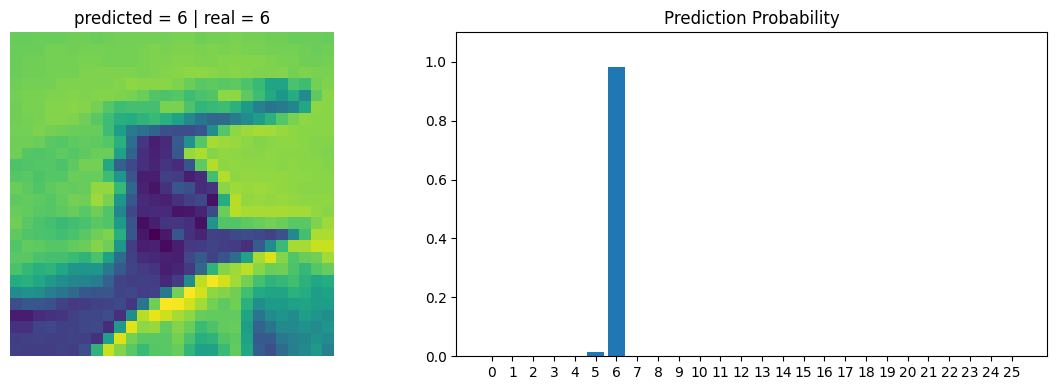

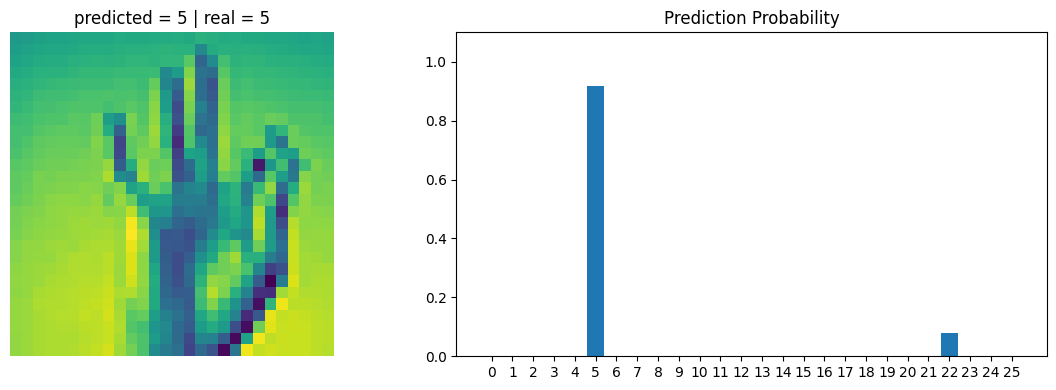

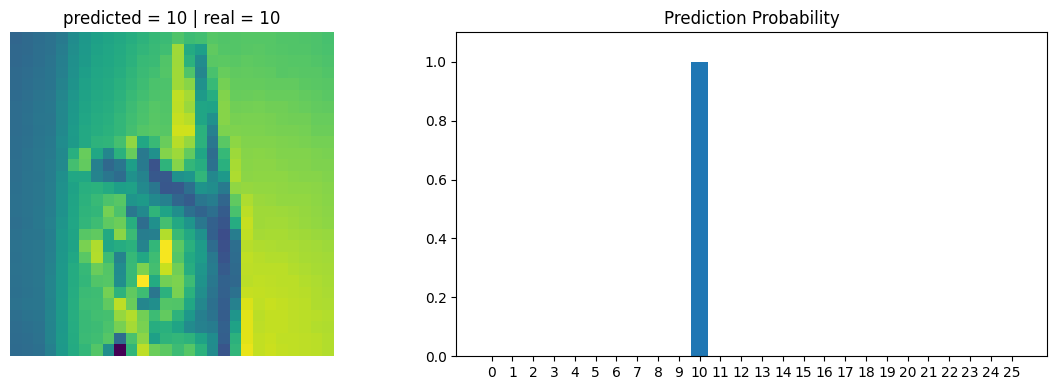

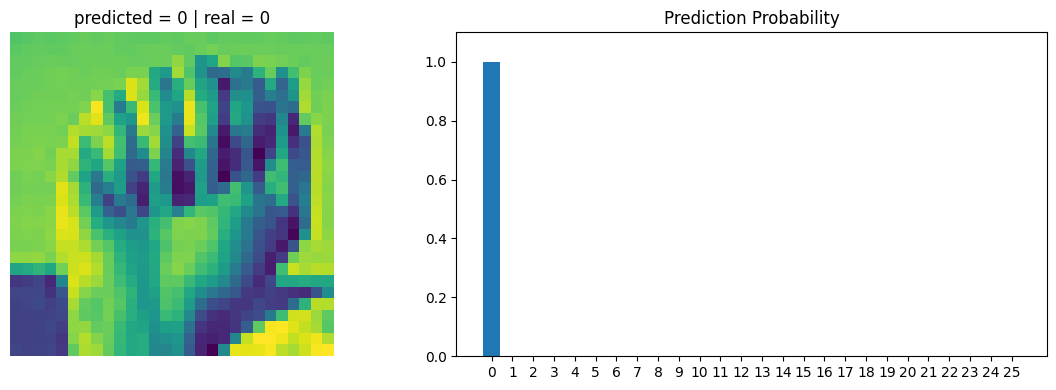

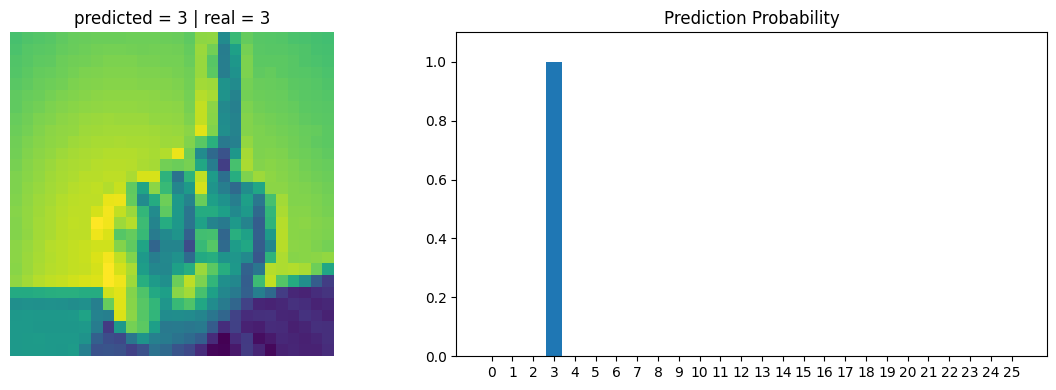

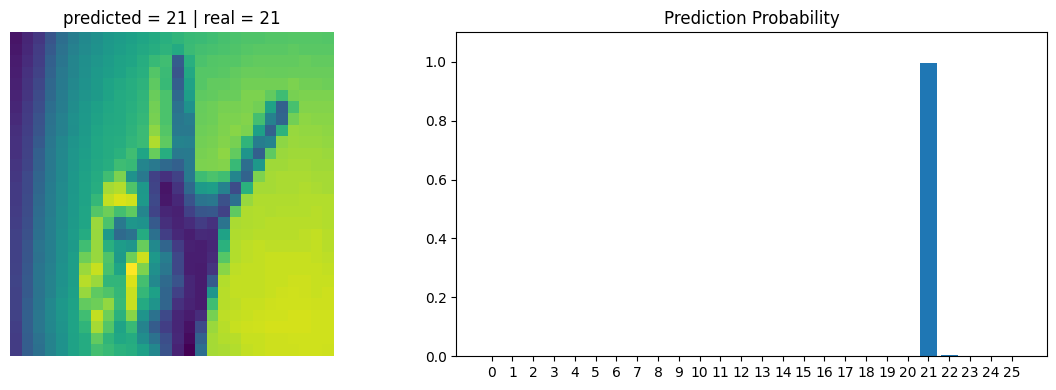

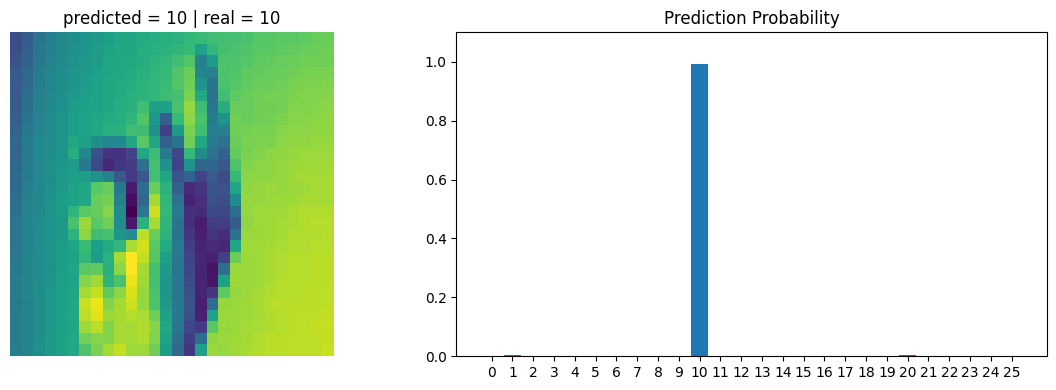

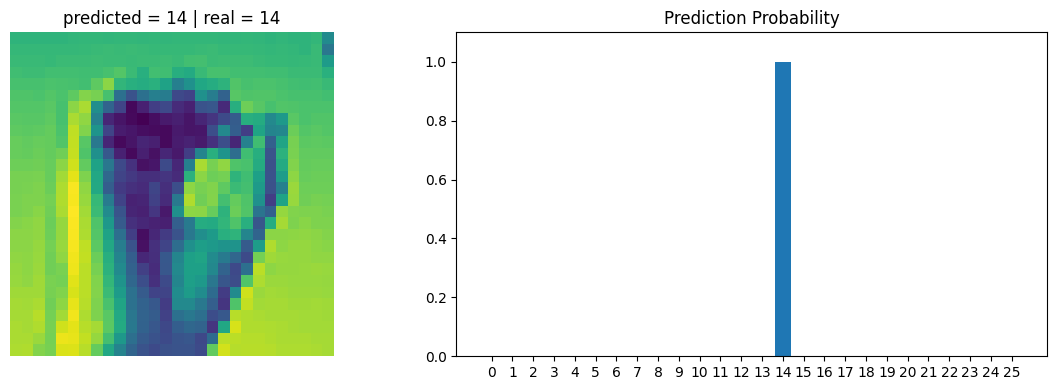

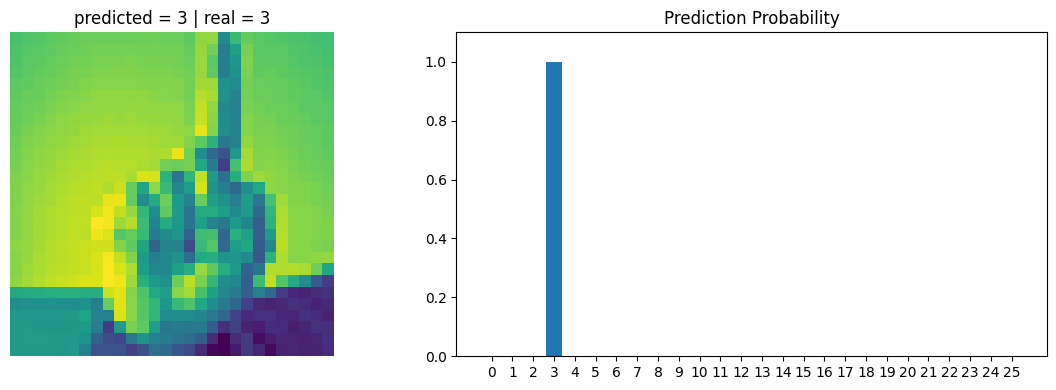

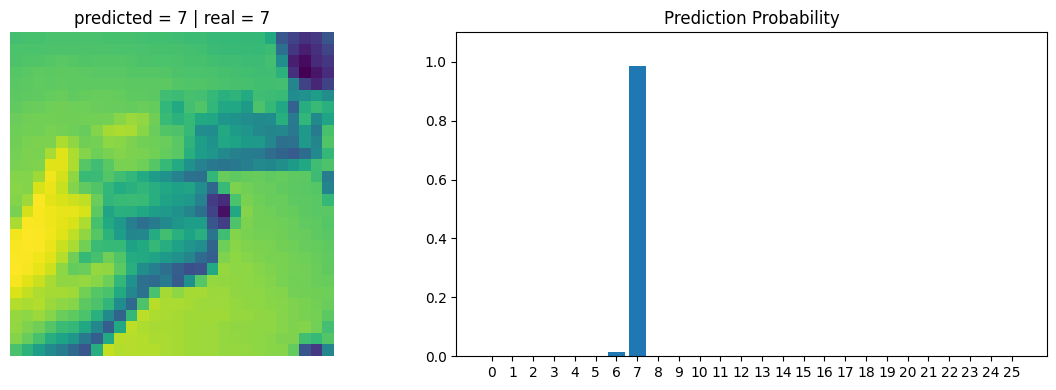

In [ ]:
visualise_performance(model)

# Dependence of CNN's on Visual information

Whether CNN's can still learn effectively from permutations of images


In the below code, the permutation parameter basically dictates the permutation of the pixels of the images. In case nothing is passed, no permutation is applied (which is what was done previously)


In [33]:
torch.manual_seed(42)
fixed_permutation = torch.randperm(784)
model = CNNDropout().to(DEVICE)
train_network(
    model,
    train_dataloader,
    test_dataloader,
    15,
    "cnndropout",
    permutation=fixed_permutation,
)

Epoch = 1: 100%|██████████| 215/215 [01:01<00:00,  3.50it/s, Loss =  3.187]


Test loss =  3.201 | Test cccuracy =  2.62


Epoch = 2: 100%|██████████| 215/215 [01:03<00:00,  3.39it/s, Loss =  3.157]


Test loss =  3.089 | Test cccuracy =  4.44


Epoch = 3: 100%|██████████| 215/215 [01:01<00:00,  3.47it/s, Loss =  2.790]


Test loss =  2.803 | Test cccuracy =  13.77


Epoch = 4: 100%|██████████| 215/215 [01:03<00:00,  3.40it/s, Loss =  2.187]


Test loss =  2.252 | Test cccuracy =  28.24


Epoch = 5: 100%|██████████| 215/215 [01:01<00:00,  3.47it/s, Loss =  2.092]


Test loss =  1.918 | Test cccuracy =  35.42


Epoch = 6: 100%|██████████| 215/215 [01:03<00:00,  3.40it/s, Loss =  1.387]


Test loss =  1.789 | Test cccuracy =  41.42


Epoch = 7: 100%|██████████| 215/215 [01:01<00:00,  3.48it/s, Loss =  1.763]


Test loss =  1.728 | Test cccuracy =  40.88


Epoch = 8: 100%|██████████| 215/215 [01:03<00:00,  3.38it/s, Loss =  1.226]


Test loss =  1.710 | Test cccuracy =  45.17


Epoch = 9: 100%|██████████| 215/215 [01:01<00:00,  3.49it/s, Loss =  1.515]


Test loss =  1.638 | Test cccuracy =  49.75


Epoch = 10: 100%|██████████| 215/215 [01:02<00:00,  3.42it/s, Loss =  1.139]


Test loss =  1.641 | Test cccuracy =  50.23


Epoch = 11: 100%|██████████| 215/215 [01:01<00:00,  3.48it/s, Loss =  0.919]


Test loss =  1.736 | Test cccuracy =  46.85


Epoch = 12: 100%|██████████| 215/215 [01:02<00:00,  3.42it/s, Loss =  0.676]


Test loss =  1.780 | Test cccuracy =  49.21


Epoch = 13: 100%|██████████| 215/215 [00:59<00:00,  3.59it/s, Loss =  0.649]


Test loss =  1.760 | Test cccuracy =  49.77


Epoch = 14: 100%|██████████| 215/215 [01:01<00:00,  3.50it/s, Loss =  0.726]


Test loss =  1.900 | Test cccuracy =  50.13


Epoch = 15: 100%|██████████| 215/215 [01:01<00:00,  3.51it/s, Loss =  0.503]


Test loss =  1.930 | Test cccuracy =  52.53


We can see here that the performance of the same model reduced from 90% to 52%


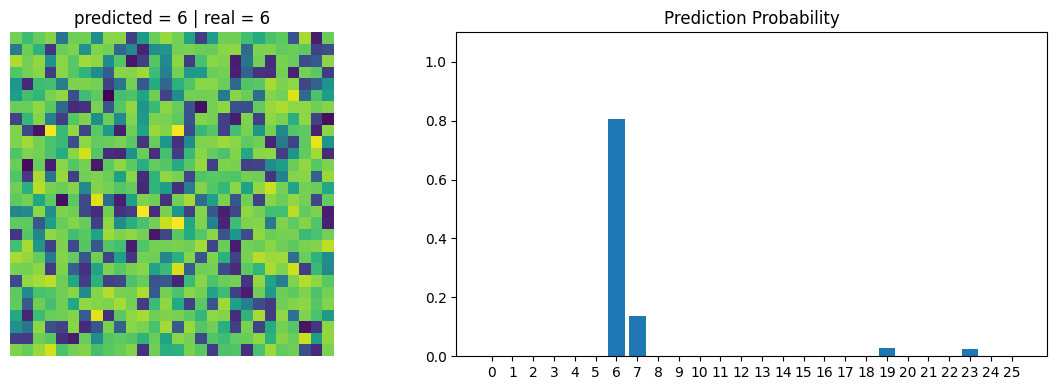

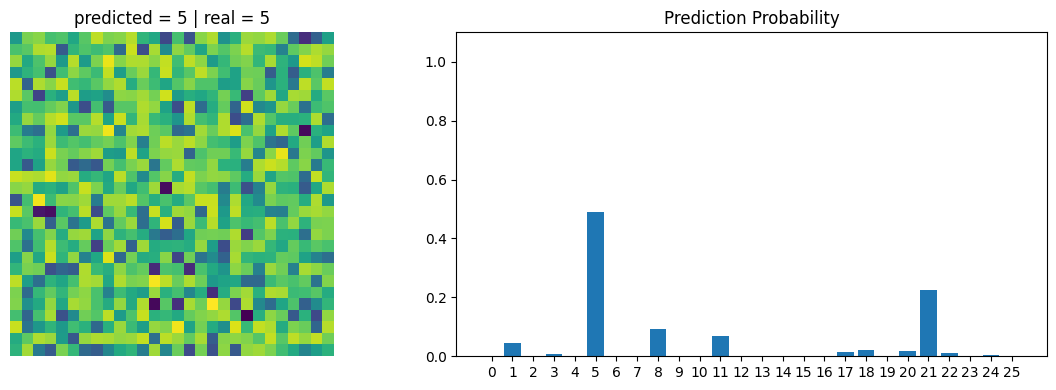

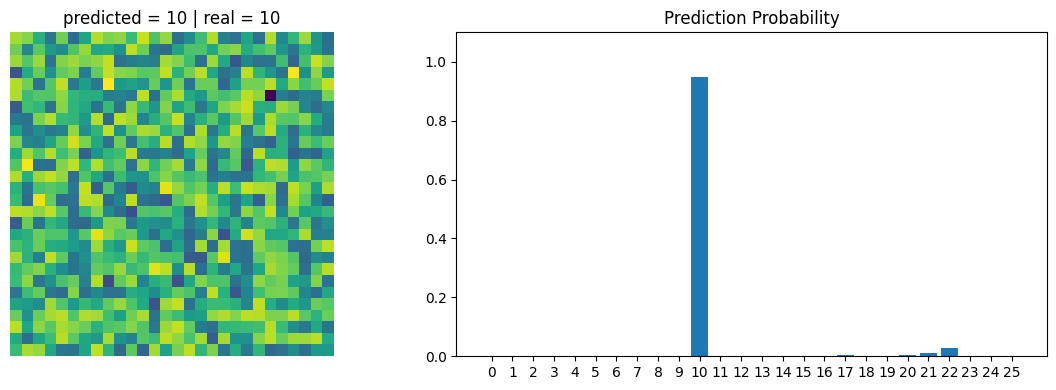

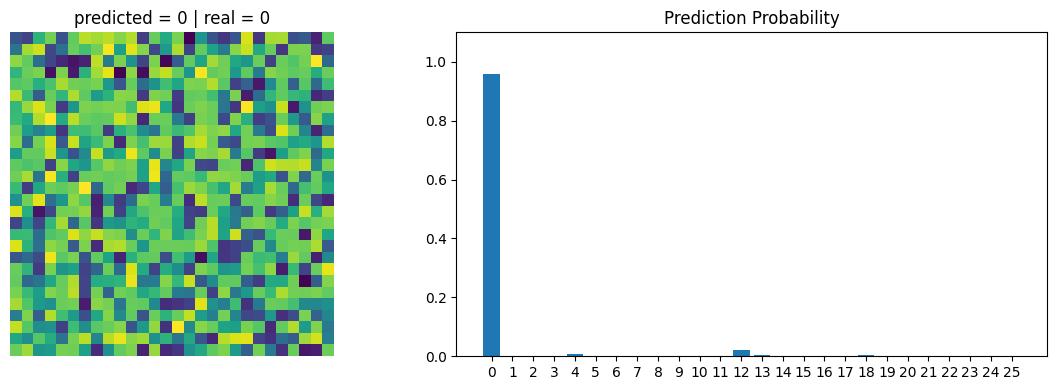

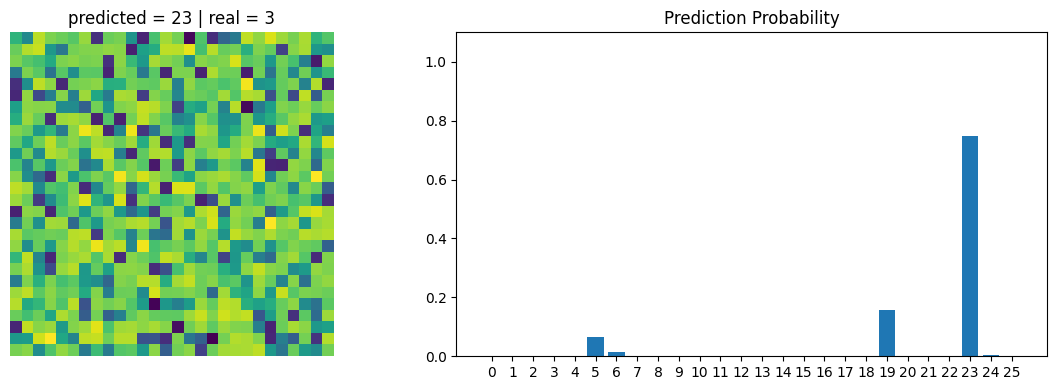

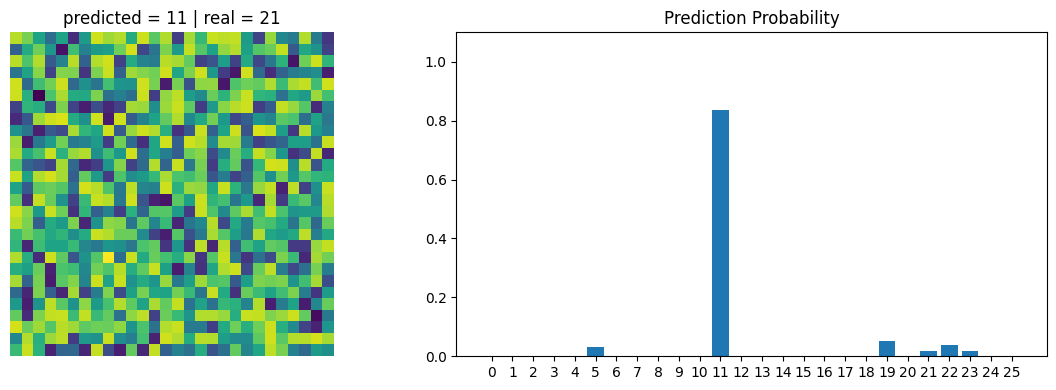

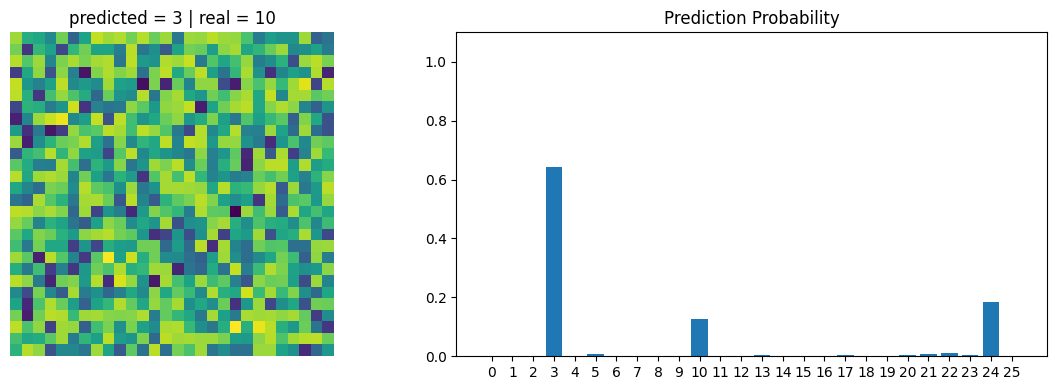

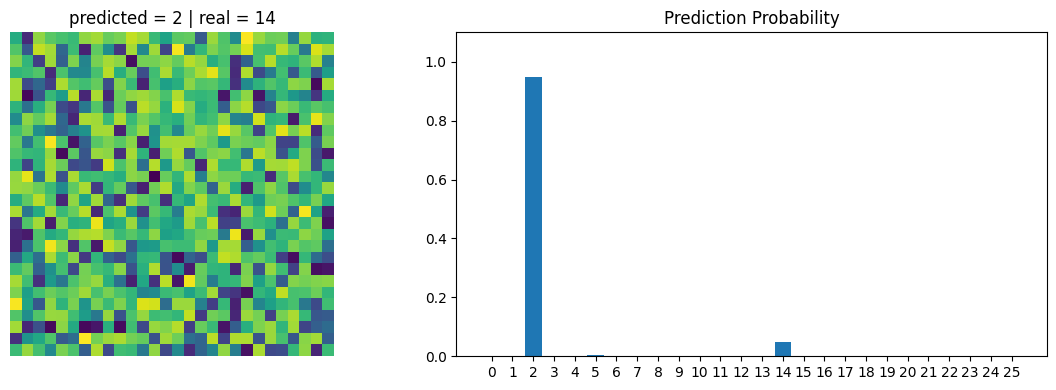

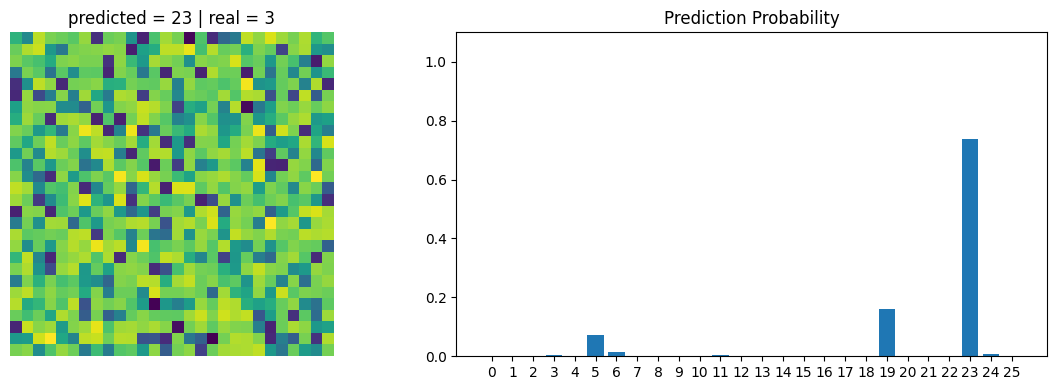

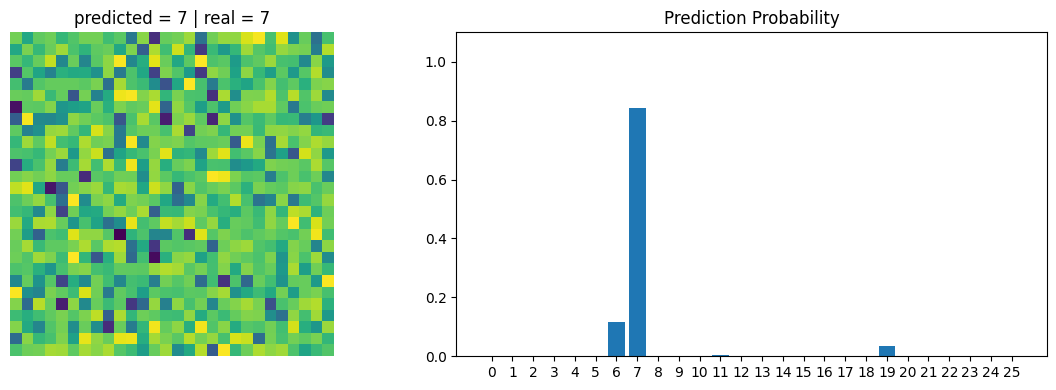

In [34]:
visualise_performance(model, fixed_permutation)

# FGSM attack


In [15]:
def fgsm_attack(image, epsilon, img_grad):
    sign_img_grad = img_grad.sign()
    perturbed_image = image + epsilon * sign_img_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [21]:
def fgsm_test(model, test, loss_fn, device, epsilon):
    correct = 0
    adversarial_examples = []
    loop = tqdm(test)
    n = len(test)
    loop.set_description_str(f"Testing FGSM attack with epsilon = {epsilon}")
    for inputs, targets in loop:
        # get the loss with respect to the actual output
        inputs, targets = inputs.to(device), targets.to(device)
        inputs.requires_grad = True
        output = model(inputs)
        initial_prediction = output.argmax(dim=1)
        if initial_prediction.item() != targets.item():
            continue

        loss = loss_fn(output, targets)
        model.zero_grad()
        loss.backward()

        # calculate the gradient based on the inputs
        img_grad = inputs.grad.data
        perturbed_inputs = fgsm_attack(inputs, epsilon, img_grad)
        output = model(perturbed_inputs)
        final_prediction = output.argmax(dim=1)

        if final_prediction.item() == targets.item():
            correct += 1
            if epsilon == 0 and len(adversarial_examples) < 5:
                example = perturbed_inputs.squeeze().detach().cpu().numpy()
                adversarial_examples.append(
                    (initial_prediction, final_prediction, example)
                )
        else:
            if len(adversarial_examples) < 5:
                example = perturbed_inputs.squeeze().detach().cpu().numpy()
                adversarial_examples.append(
                    (initial_prediction, final_prediction, example)
                )

        loop.set_postfix_str(
            f"Correct samples = {correct}/{n} | Accuracy = {correct * 100 / float(n): .3f}"
        )

    final_accuracy = correct / float(n)
    return final_accuracy, adversarial_examples

In [22]:
accuracies = []
examples = []
epsilons = [0, 0.005, 0.05, 0.1, 0.5, 1]

model = CNNDropout().to(DEVICE)
model.load_state_dict(torch.load("assignment-1/saved-model/cnndropout.pth"))
model.eval()

loss_fn = nn.NLLLoss().to(DEVICE)

fgsm_testloader = DataLoader(test_data, batch_size=1)
for e in epsilons:
    acc, ex = fgsm_test(model, fgsm_testloader, loss_fn, DEVICE, e)
    accuracies.append(acc)
    examples.append(ex)

Testing FGSM attack with epsilon = 1: 100%|██████████| 7172/7172 [00:52<00:00, 136.25it/s, Correct samples = 43/7172 | Accuracy =  0.600]


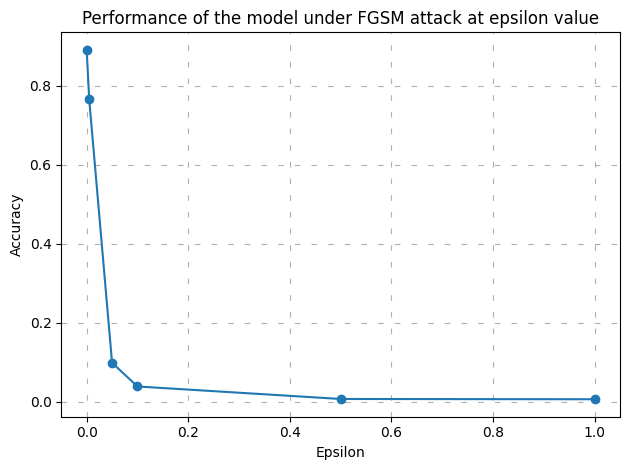

In [23]:
plt.plot(epsilons, accuracies, marker="o")
plt.grid(True, "major", axis="both", ls=(0, (5, 10)))
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.title("Performance of the model under FGSM attack at epsilon value")
plt.tight_layout()
plt.show()

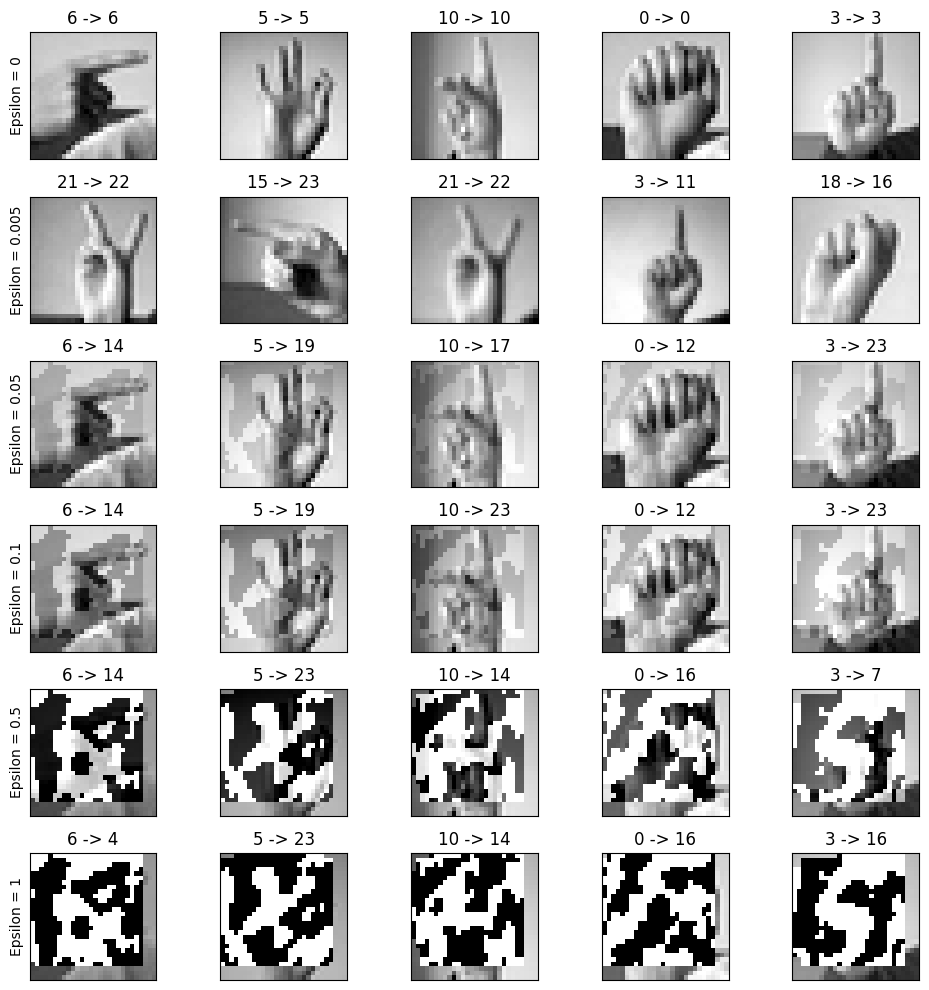

In [32]:
fig, axs = plt.subplots(len(epsilons), 5, figsize=(10, 10))
for i, e in enumerate(epsilons):
    for j, ax in enumerate(axs[i]):
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        if j == 0:
            ax.set_ylabel(f"Epsilon = {e}")
        orig, adv, ex = examples[i][j]
        ax.set_title(f"{orig.item()} -> {adv.item()}")
        ax.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()